In [25]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from itertools import chain
import cartopy.crs as ccrs
import cartopy
import netCDF4 as nc 
import pickle
from scipy.odr import ODR, Model, Data, RealData
from matplotlib import gridspec
from scipy.stats import linregress
from pyproj import Proj, Transformer
from scipy.interpolate import griddata
import os


In [26]:
def draw_map(m, scale=0.2):
    # draw a shaded-relief image
    # m.shadedrelief(scale=scale)
    m.drawlsmask(land_color='gray',ocean_color='white',lakes=True)
    # lats and longs are returned as a dictionary
    lats = m.drawparallels(np.linspace(-90, 90, 13))
    lons = m.drawmeridians(np.linspace(-180, 180, 13))

    # keys contain the plt.Line2D instances
    lat_lines = chain(*(tup[1][0] for tup in lats.items()))
    lon_lines = chain(*(tup[1][0] for tup in lons.items()))
    all_lines = chain(lat_lines, lon_lines)
    
    # cycle through these lines and set the desired style
    for line in all_lines:
        line.set(linestyle='-', alpha=0.3, color='w')

def mask_observations(observations, inversion):
    new_inversion = np.copy(inversion)
    for i in range(len(observations)):
        for j in range(len(observations[0])):
            if np.isnan(observations[i][j]):
                new_inversion[i][j] = np.nan
    return new_inversion


def mask_high_error(stddev, inversion):
    new_inversion = np.copy(inversion)
    for i in range(len(stddev)):
        for j in range(len(stddev[0])):
            if stddev[i][j] >= inversion[i][j]*(20/100):
                new_inversion[i][j] = np.nan
    return new_inversion


def mask_sie(sie_map, inversion):
    new_inversion = np.copy(inversion)
    for i in range(len(sie_map)):
        for j in range(len(sie_map[0])):
            if not np.isnan(sie_map[i][j]) and sie_map[i][j] < 0.7:
                new_inversion[i][j] = np.nan
    return new_inversion

def model_func(beta, x):
    m, b = beta  # beta contient les paramètres du modèle (pente, ordonnée à l'origine)
    return m * x + b


def pearson(inverse, OIB):
    # pearson coefficient
    ydata = np.array(inverse)
    yfit = np.array(OIB)

    ydata_mean = np.mean(ydata)
    yfit_mean = np.mean(yfit)

    data_diff = ydata - ydata_mean
    fit_diff = yfit - yfit_mean

    top = np.sum( (data_diff) * (fit_diff) )

    bottom = np.sqrt( np.sum(data_diff**2) * np.sum(fit_diff**2) )

    r = top/bottom

    return r

def analyse (calculated_data, validation_data):
    error = np.array(calculated_data) - np.array(validation_data)
    md = np.mean(error)
    rmse = np.sqrt( np.mean( (error)**2 ))
    residuals = error**2
    denom = (calculated_data - np.mean(calculated_data)) ** 2
    r2 = 1 - (np.sum(residuals) / np.sum(denom))

    # Calculate slope and y-intercept
    #slope, intercept = np.polyfit(validation_data, calculated_data, 1)
    data = RealData(validation_data, calculated_data)
    model = Model(model_func)
    beta0 = [1.0, 0.0]
    odr = ODR(data, model, beta0=beta0)
    output = odr.run()

    slope = output.beta[0]
    intercept = output.beta[1]


    return md, rmse, r2, slope, intercept

def lonlat_to_xy(coords_1, coords_2, hemisphere, inverse=False):

    """Converts between longitude/latitude and EASE xy coordinates.
 
    Args:
        lon (float): WGS84 longitude
        lat (float): WGS84 latitude
        hemisphere (string): 'n' or 's'
        inverse (bool): if true, converts xy to lon/lat
 
    Returns:
        tuple: pair of xy or lon/lat values
    """

    EASE_Proj = {'n': 'EPSG:3408',
                 's': 'EPGS:3409'}
    
    WGS_Proj = 'EPSG:4326'
    
    #for coords in [coords_1, coords_2]: assert isinstance(coords,(np.ndarray,list))

    if inverse == False: # lonlat to xy
        
        lon, lat = coords_1, coords_2
        
        transformer = Transformer.from_crs(WGS_Proj, EASE_Proj[hemisphere])
        
        x, y = transformer.transform(lat, lon)
        
        return (x, y)

    else: # xy to lonlat
        
        x, y = coords_1, coords_2
        
        transformer = Transformer.from_crs(EASE_Proj[hemisphere], WGS_Proj)
        
        lat, lon = transformer.transform(x, y)
        
        return (lon, lat)


In [27]:
## Validation against OIB

OIB_files = ["/home/erb/masterproject/MSCI_project/validation_data/OIB_data/OIB_201904/20190408.nc",
             "/home/erb/masterproject/MSCI_project/validation_data/OIB_data/OIB_201904/20190412.nc",
             "/home/erb/masterproject/MSCI_project/validation_data/OIB_data/OIB_201904/20190419.nc",
             "/home/erb/masterproject/MSCI_project/validation_data/OIB_data/OIB_201904/20190420.nc",
             "/home/erb/masterproject/MSCI_project/validation_data/OIB_data/OIB_201904/20190422.nc"]

awi_file = ['/home/erb/masterproject/MSCI_project/validation_data/AWI/2.6_AWI_data/2019/awi-siral-l3c-sithick-cryosat2-rep-nh_25km_ease2-201904-fv2p6.nc']

awi = nc.Dataset(awi_file[0])
awi.variables.keys()
SD_awi = awi.variables['snow_depth'][0][36:396,36:396][::-1, :]

lon_g = np.load("/home/erb/masterproject/MSCI_project/new_lon_25km.npy")
lat_g = np.load("/home/erb/masterproject/MSCI_project/new_lat_25km.npy")

sie_path = '/home/erb/masterproject/MSCI_project/snow_ice/carmen/SIE/SIE_masking_25km_2018-2019_season.pkl'
f = open(sie_path,'rb')
sie_file = pickle.load(f)
sie_map  = sie_file['20190415']


SD_uit = np.load('/home/erb/masterproject/MSCI_project/validation_data/UIT_data/snow_201904_EASE2_laku_UIT.npy')


/tmp/ipykernel_407589/1112533407.py:13: UserWarning: WARNING: valid_min not used since it
cannot be safely cast to variable data type
  SD_awi = awi.variables['snow_depth'][0][36:396,36:396][::-1, :]
/tmp/ipykernel_407589/1112533407.py:13: UserWarning: WARNING: valid_max not used since it
cannot be safely cast to variable data type
  SD_awi = awi.variables['snow_depth'][0][36:396,36:396][::-1, :]


In [28]:
lon_g = np.load("/home/erb/masterproject/MSCI_project/new_lon_25km.npy")
lat_g = np.load("/home/erb/masterproject/MSCI_project/new_lat_25km.npy")

IS2 = [np.load("/home/erb/masterproject/MSCI_project/snow_ice/carmen/daily_numpys/IS2/FB_interp_2018_25km_20181115.npy"),
        np.load("/home/erb/masterproject/MSCI_project/snow_ice/carmen/daily_numpys/IS2/FB_interp_2019_25km_20190415.npy"),
        np.load("/home/erb/masterproject/MSCI_project/snow_ice/carmen/daily_numpys/IS2/FB_interp_2019_25km_20191115.npy"),
        np.load("/home/erb/masterproject/MSCI_project/snow_ice/carmen/daily_numpys/IS2/FB_interp_2020_25km_20200415.npy"),
        np.load("/home/erb/masterproject/MSCI_project/snow_ice/carmen/daily_numpys/IS2/FB_interp_2020_25km_20201115.npy"),
        np.load("/home/erb/masterproject/MSCI_project/snow_ice/carmen/daily_numpys/IS2/FB_interp_2021_25km_20210415.npy")]


amsr2_snow_files = ['/home/erb/masterproject/MSCI_project/validation_data/AMSR2_data/mpr_retrieval_amsr_20190415_ease_25_v0.2.nc']

import xarray as xr

def get_pm_bremen_snow_lonlats():
    fpath = '/home/erb/masterproject/MSCI_project/validation_data/AMSR2/mpr_retrieval_amsr_20181115_ease_25_v0.2.nc'
    ds = xr.open_dataset(fpath)
    return ds['lon'].values, ds['lat'].values

def get_pm_bremen_snow_values(fpath):
    # fpath = '/home/cn/Sentinel3Snod/DATA/Bremen_snow/2019/03/snowdepth_amsr2_20190315v1.1.nc'
    ds = xr.open_dataset(fpath)
    return ds['snd'].values



lon_AMSR2, lat_AMSR2 = get_pm_bremen_snow_lonlats()
# snow_AMSR2, snow_unc_AMSR2 = get_pm_bremen_snow_values()

x_AMSR2, y_AMSR2 = lonlat_to_xy(lon_AMSR2, lat_AMSR2, "n", inverse=False)

lon_g = np.load("/home/erb/masterproject/MSCI_project/new_lon_25km.npy")
lat_g = np.load("/home/erb/masterproject/MSCI_project/new_lat_25km.npy")

x_EASE2, y_EASE2 = lonlat_to_xy(lon_g, lat_g, "n", inverse=False)


def snow_amsr2(path_awismos):

    snow_AMSR2 = get_pm_bremen_snow_values(path_awismos)
    snow_AMSR2_EASE2 = griddata((x_AMSR2.ravel(), y_AMSR2.ravel()), snow_AMSR2.ravel(), (x_EASE2, y_EASE2), method='nearest')
    #snow_AMSR2_EASE2 = snow_AMSR2_EASE2/100.
    snow_AMSR2_EASE2 = snow_AMSR2_EASE2
    return snow_AMSR2_EASE2

def inverse_snow(inverse_snow_files, path_awismos):
    snow_inverse, ST_amsr2 = [], []

    snow_AMSR2 = get_pm_bremen_snow_values(path_awismos)
    snow_AMSR2_EASE2 = griddata((x_AMSR2.ravel(), y_AMSR2.ravel()), snow_AMSR2.ravel(), (x_EASE2, y_EASE2), method='nearest')
    #snow_AMSR2_EASE2 = snow_AMSR2_EASE2/100.
    snow_AMSR2_EASE2 = snow_AMSR2_EASE2
    
    snow_inverse_data = np.load(inverse_snow_files)

    for k in range(360):
        for j in range(360):
        #if not SIT_awismos.mask[k][j] and not np.isnan(ice_inverse_data[k][j]):
            if not np.isnan(snow_inverse_data[k][j]) and not np.isnan(snow_AMSR2_EASE2[k][j]):
                snow_inverse.append(snow_inverse_data[k][j])
                ST_amsr2.append(snow_AMSR2_EASE2[k][j])
    
    return snow_inverse, ST_amsr2

In [29]:
def snow_OIB(OIB_files):

    SD_OIB = nc.Dataset(OIB_files).variables['Snow Depth'][:,:]
    return SD_OIB

In [30]:
SD_amsr = snow_amsr2(amsr2_snow_files[0])

SD_OIB, SD_OIB_awi, SD_OIB_amsr = [], [], []
SD_OIB_uit = []
snow_inverse = []
snow_awismos = []
snow_uit = []
snow_amsr = []


for i in range(len(OIB_files)):
    
    file_OIB = snow_OIB(OIB_files[i])
    inverse_snow_data = np.load('/home/erb/masterproject/MSCI_project/snow_ice/CS_IS_2p_LARM/results_npy/non_interpolated_input/201904/15tesselationDelaunay_initcell1500_iteration1500000_date_window15j_icedensitymixte_alphacs20.75_hierarchicalno_snow.npy')
    inverse_snow_stddev = np.load('/home/erb/masterproject/MSCI_project/snow_ice/CS_IS_2p_LARM/results_npy/non_interpolated_input/201904/15tesselationDelaunay_initcell1500_iteration1500000_date_window15j_icedensitymixte_alphacs20.75_hierarchicalno_snow_stddev.npy')

    inverse_snow_data = mask_high_error(inverse_snow_stddev, inverse_snow_data)

    for k in range(360):
        for j in range(360):
            if not (file_OIB.mask[k][j]) and not np.isnan(inverse_snow_data[k][j]):
                snow_inverse.append(inverse_snow_data[k][j])
                SD_OIB.append(file_OIB[k][j])


for i in range(len(OIB_files)):
    
    file_OIB = snow_OIB(OIB_files[i])

    for k in range(360):
        for j in range(360):
            if not (file_OIB.mask[k][j]) and not np.isnan(SD_awi[k][j]):
                snow_awismos.append(SD_awi[k][j])
                SD_OIB_awi.append(file_OIB[k][j])


for i in range(len(OIB_files)):
    
    file_OIB = snow_OIB(OIB_files[i])

    for k in range(360):
        for j in range(360):
            if not (file_OIB.mask[k][j]) and not np.isnan(SD_uit[k][j]):
                snow_uit.append(SD_uit[k][j])
                SD_OIB_uit.append(file_OIB[k][j])

for i in range(len(OIB_files)):
    
    file_OIB = snow_OIB(OIB_files[i])

    for k in range(360):
        for j in range(360):
            if not (file_OIB.mask[k][j]) and not np.isnan(SD_amsr[k][j]):
                snow_amsr.append(SD_amsr[k][j])
                SD_OIB_amsr.append(file_OIB[k][j])

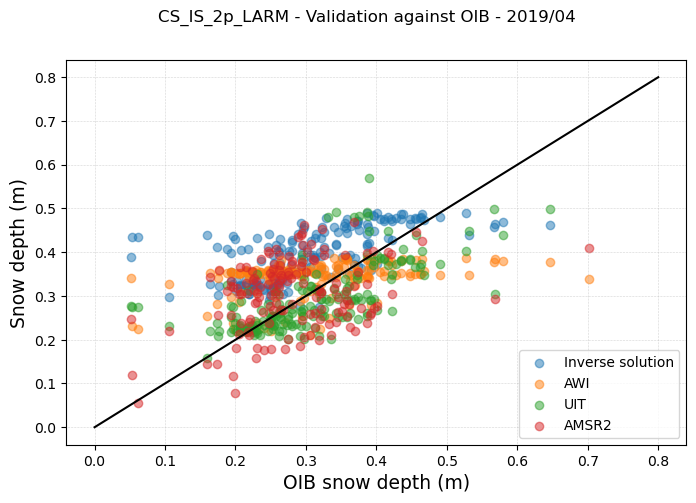

In [31]:
fig = plt.figure(figsize = (8, 5))
plt.suptitle('CS_IS_2p_LARM - Validation against OIB - 2019/04')


plt.scatter(SD_OIB, snow_inverse, alpha = 0.5, label = 'Inverse solution')
plt.scatter(SD_OIB_awi, snow_awismos, alpha = 0.5, label = 'AWI')
plt.scatter(SD_OIB_uit, snow_uit, alpha = 0.5, label = 'UIT')
plt.scatter(SD_OIB_amsr, snow_amsr, alpha = 0.5, label = 'AMSR2')
plt.plot([0,0.8] , [0,0.8], 'k-')
plt.grid(linestyle='dotted', linewidth ='0.4')
plt.xlabel('OIB snow depth (m)', fontsize = 13.5)
plt.ylabel('Snow depth (m)', fontsize = 13.5)
plt.legend(loc = 'lower right')

md_snow_inverse, rmse_snow_inverse, r2_snow_inverse, slope, intercept = analyse(snow_inverse, SD_OIB)
r_snow = pearson(SD_OIB, snow_inverse)

textstr = '\n'.join((
    rf'Inverse solution',
    rf'$Num = {len(snow_inverse)}$',
    rf'$Bias={md_snow_inverse:.2f}$',
    rf'$RMSE={rmse_snow_inverse:.2f}$',
    rf'$r = {r_snow:.2f}$',
    rf'$Slope = {slope:.2f}$',
    rf'$Intercept = {intercept:.2f}$'))
box_props = dict(boxstyle='square', facecolor= 'white', alpha=0.5)
#plt.text(0, 0.8, textstr, bbox=box_props, verticalalignment='top')

x_values = np.array([0,0.8])
y_values = slope * x_values + intercept


md_snow_inverse, rmse_snow_inverse, r2_snow_inverse, slope, intercept = analyse(snow_awismos, SD_OIB_awi)
r_snow = pearson(SD_OIB_awi, snow_awismos)

textstr = '\n'.join((
    rf'AWI',
    rf'$Num = {len(SD_awi)}$',
    rf'$Bias={md_snow_inverse:.2f}$',
    rf'$RMSE={rmse_snow_inverse:.2f}$',
    rf'$r = {r_snow:.2f}$',
    rf'$Slope = {slope:.2f}$',
    rf'$Intercept = {intercept:.2f}$'))
box_props = dict(boxstyle='square', facecolor= 'white', alpha=0.5)
#plt.text(0.18, 0.8, textstr, bbox=box_props, verticalalignment='top')

# Regression line
x_values = np.array([0,0.8])
y_values = slope * x_values + intercept

md_snow_inverse, rmse_snow_inverse, r2_snow_inverse, slope, intercept = analyse(snow_uit, SD_OIB_uit)
r_snow = pearson(SD_OIB_uit, snow_uit)

textstr = '\n'.join((
    rf'UIT',
    rf'$Num = {len(SD_uit)}$',
    rf'$Bias={md_snow_inverse:.2f}$',
    rf'$RMSE={rmse_snow_inverse:.2f}$',
    rf'$r = {r_snow:.2f}$',
    rf'$Slope = {slope:.2f}$',
    rf'$Intercept = {intercept:.2f}$'))
box_props = dict(boxstyle='square', facecolor= 'white', alpha=0.5)
#plt.text(0.36, 0.8, textstr, bbox=box_props, verticalalignment='top')

# Regression line
x_values = np.array([0,0.8])
y_values = slope * x_values + intercept

md_snow_inverse, rmse_snow_inverse, r2_snow_inverse, slope, intercept = analyse(snow_amsr, SD_OIB_amsr)
r_snow = pearson(SD_OIB_amsr, snow_amsr)

textstr = '\n'.join((
    rf'AMSR2',
    rf'$Num = {len(SD_amsr)}$',
    rf'$Bias={md_snow_inverse:.2f}$',
    rf'$RMSE={rmse_snow_inverse:.2f}$',
    rf'$r = {r_snow:.2f}$',
    rf'$Slope = {slope:.2f}$',
    rf'$Intercept = {intercept:.2f}$'))
box_props = dict(boxstyle='square', facecolor= 'white', alpha=0.5)
#plt.text(0.54, 0.8, textstr, bbox=box_props, verticalalignment='top')

# Regression line
x_values = np.array([0,0.8])
y_values = slope * x_values + intercept


save_fig = 1
if save_fig ==1 :
    plt.savefig('/home/erb/masterproject/MSCI_project/snow_ice/CS_IS_2p_LARM/validation/validation_snow_oib_csis2p_delaunay.png', dpi = 300)

